In [111]:
import os
import sys
import torch
from pytorch3d.io import load_objs_as_meshes, load_obj
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV,
    TexturesVertex
)
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from typing import NamedTuple, Sequence, Union
import cv2
import matplotlib.image as mpimg

In [112]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
mesh = load_objs_as_meshes(['nimrud.obj'], device=device)

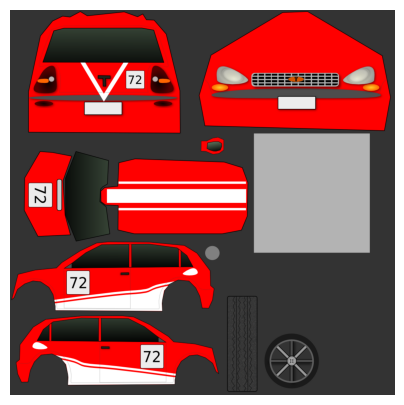

In [113]:
plt.figure(figsize=(5,5))
texture_image=mesh.textures.maps_padded()
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.axis("off");

tensor([[[[1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          ...,
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]],

         [[1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          ...,
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]],

         [[1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          ...,
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]],

         ...,

         [[1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          ...,
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]],

         [[1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          ...,
          [1., 1., 1., 0.],
          [1., 1., 1., 0.],
          [1., 1., 1., 0.]],

         [[1., 1., 1., 0.],
          [1., 1., 1., 0.],
    

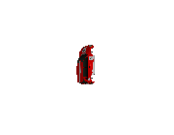

In [114]:
R, T = look_at_view_transform(-20, 170, 50)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

raster_settings = RasterizationSettings(image_size=(120, 160), blur_radius=0.0, faces_per_pixel=1)
lights = PointLights(device=device, location=[[5.0 , 0.0, 0.0]])
rasterizer=MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader=SoftPhongShader(device=device, cameras=cameras, lights=lights)

verts_shape = mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)
mesh = mesh.offset_verts(deform_verts)

fragments = rasterizer.forward(mesh)
images = shader(fragments, mesh)
print(images)

# images = renderer(mesh)
plt.figure(figsize=(160/80, 120/80))
plt.imshow(images[0, ..., :3].detach().cpu().numpy())
plt.axis("off")
plt.savefig('new.png', dpi=80)

In [115]:
N, H, W, K = fragments.pix_to_face.shape
device = fragments.pix_to_face.device

# Mask for the background.
is_background = fragments.pix_to_face[..., 0] < 0  # (N, H, W)
print(is_background.shape)

torch.Size([1, 120, 160])


In [116]:
background = torch.tensor(cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/10.png'), device=device).float() / 255.0
print(background.shape)
print(is_background.shape)
print(images.shape)

combined = background.unsqueeze(0) * is_background.unsqueeze(-1) + torch.flip(images[...,:3], [-1]) * torch.logical_not(is_background.unsqueeze(-1))
overlay = cv2.imread('/home/vdamarla/adversarial-vehicle-testing/src/adversarial_vehicle_testing/car/new.png', cv2.IMREAD_UNCHANGED)
cv2.imwrite('combined.png', combined[0].detach().cpu().numpy() * 255)

torch.Size([120, 160, 3])
torch.Size([1, 120, 160])
torch.Size([1, 120, 160, 4])


True